In [13]:
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
sys.path.append('/home/kal/K27act_models/convolution_model/')
sys.path.append('/home/kal/K27act_models/cg_model/')
sys.path.append('/home/thouis/basenji_embeddings')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tf_memory_limit
from zinb import ZINB
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from keras.utils import plot_model

import pandas as pd
import numpy as np
import itertools
import sequence
import ucscgenome
from tqdm import tqdm
import time
import datagen
import sequence
import helper
import viz_sequence
import pickle

from keras.models import Model, load_model
from keras.layers import Input, Dense, SpatialDropout1D, Conv1D, Lambda, Dropout, Activation
from keras.optimizers import RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
#load in the DNA
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

In [3]:
# load in ATAC data
atac_path = '/home/kal/K27act_models/GM_data/ATAC/atac_average.hdf5'
atac = h5py.File(atac_path, 'r')

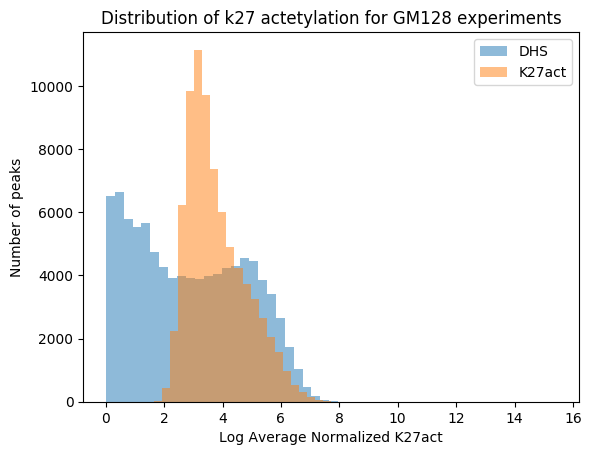

In [4]:
# load in preprocessed data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
#note we make the 'k27act' column the 'score' column for the correct training behavior
peaks.columns='chr start end name fold_change atac score nucs'.split() 

bins=50
plt.hist(np.log2(peaks[['dhs' in n for n in peaks['name']]]['score'] + 1), label='DHS', alpha=0.5, bins=bins)
plt.hist(np.log2(peaks[['k27' in n for n in peaks['name']]]['score'] + 1), label='K27act', alpha=0.5, bins=bins)
plt.ylabel('Number of peaks')
plt.xlabel('Log Average Normalized K27act')
plt.title('Distribution of k27 actetylation for GM128 experiments')
plt.legend()
plt.show()

In [5]:
# facts about the data
num_training_samples = len(peaks[(peaks.chr != 'chr8')])
print('{} training samples'.format(num_training_samples))

num_testing_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 0)])
print('{} testing samples'.format(num_testing_samples))

num_validaiton_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)])
print('{} validation samples'.format(num_validaiton_samples))

160363 training samples
3413 testing samples
3414 validation samples


In [27]:
# directory stuff
out_dir = '/home/kal/K27act_models/convolution_model/'
timestr = time.strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(out_dir, timestr + '_counts_conv')
os.makedirs(out_path)
# make a file system
weights_path = os.path.join(out_path, 'intermediate_weights')
os.makedirs(weights_path)
history_path = os.path.join(out_path, 'history')
os.makedirs(history_path)

In [28]:
# MODEL
batch_size=32
seqs = Input(batch_shape=(batch_size, 1024, 5))

def add_RC(x):
    RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][::-1]], axis=2)
    return K.concatenate([x, RC], axis=0)
def add_RC_shape(s):
    return 2*s[0], s[1], s[2]

conv = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)(seqs)

for k, n in [[32, 3], [32, 32], [32, 3], [32, 3]]:
    conv = Conv1D(k, n)(conv)
    conv = SpatialDropout1D(.05)(conv)

out = Dense(16)(conv) 
out = Dropout(.1)(out)
out = Dense(16)(out)
out = Dropout(.1)(out)
out = Dense(1)(out)

def max_by_direction(x):
    forward_max = K.max(x[:x.shape[0]//2, :, :], axis=1)
    reverse_max = K.max(x[x.shape[0]//2:, ::-1, :], axis=1)
    return K.maximum(forward_max, reverse_max)
def max_by_direction_shape(s):
    return s[0]//2, 1

wide_scan = Conv1D(1, 128, use_bias=False, kernel_initializer='ones', trainable=False, name='wide_scan', padding='valid')

scan = Lambda(max_by_direction, name='max_by_direciton', output_shape=max_by_direction_shape)(wide_scan(out))
predictions =  Activation('relu')(scan)
model = Model(inputs=seqs, outputs=predictions)

#plot model
plot_model(model, to_file=os.path.join(out_path, 'model.png'))

In [29]:
from keras.optimizers import RMSprop, SGD, Adam

opt = RMSprop(lr=1e-6)
model.compile(optimizer=opt, loss='mean_squared_error') 

early_stop = EarlyStopping(monitor='val_loss', patience=100)
filepath = os.path.join(weights_path, 'weights-{epoch:02d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

losses = model.fit_generator(datagen.batch_gen(peaks, mode='train', log=True), 
                             steps_per_epoch=num_training_samples//batch_size, 
                             epochs=20, callbacks=[early_stop, checkpoint], 
                             validation_data=datagen.batch_gen(peaks, mode='val', log=True), 
                             validation_steps=num_validaiton_samples//batch_size, verbose=2)




val_hist = losses.history['val_loss']
train_hist = losses.history['loss']

Epoch 1/20
 - 318s - loss: 17492.4027 - val_loss: 46.0696

Epoch 00001: val_loss improved from inf to 46.06960, saving model to /home/kal/K27act_models/convolution_model/20180709_152439_counts_conv/intermediate_weights/weights-01-46.070.hdf5
Epoch 2/20
 - 369s - loss: 1656.5785 - val_loss: 13.9768

Epoch 00002: val_loss improved from 46.06960 to 13.97680, saving model to /home/kal/K27act_models/convolution_model/20180709_152439_counts_conv/intermediate_weights/weights-02-13.977.hdf5
Epoch 3/20
 - 370s - loss: 693.4918 - val_loss: 13.3287

Epoch 00003: val_loss improved from 13.97680 to 13.32871, saving model to /home/kal/K27act_models/convolution_model/20180709_152439_counts_conv/intermediate_weights/weights-03-13.329.hdf5
Epoch 4/20
 - 372s - loss: 286.5152 - val_loss: 13.3305

Epoch 00004: val_loss did not improve from 13.32871
Epoch 5/20
 - 372s - loss: 329.2470 - val_loss: 13.2822

Epoch 00005: val_loss improved from 13.32871 to 13.28218, saving model to /home/kal/K27act_models/con

In [20]:
# final save
model.save(os.path.join(out_path, 'final_model.h5'))

In [21]:
# write out history
pickle.dump(losses.history, open(os.path.join(history_path, 'history.pk'), 'wb'))

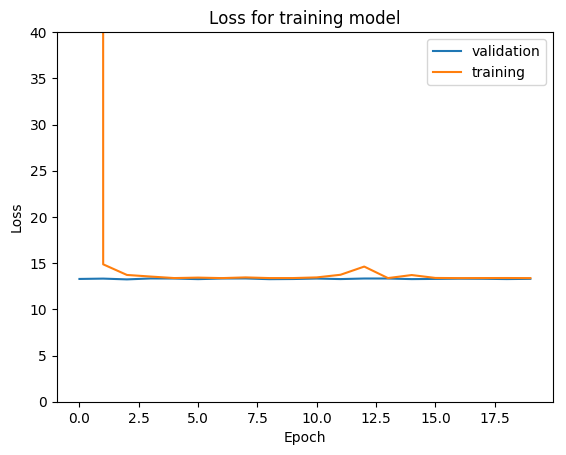

In [26]:
# look at loss
plt.plot(val_hist, label='validation')
plt.plot(train_hist, label='training')
plt.title('Loss for training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 40)
plt.legend()
plt.show()